In [1]:
import numpy as np, seaborn as sns, matplotlib.pyplot as plt, pandas as pd, gzip, math, scipy.optimize
from sklearn.linear_model import LinearRegression
from sklearn. metrics import r2_score, mean_squared_error, classification_report
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from collections import defaultdict

from sklearn import svm

### Loading Data from JSON (DO NOT RUN)

Note: Do NOT run this section as this section is how we produced "raw_data.csv". The csv can directly be downloaded from Google Drive as we have difficulties uploading large files.

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)
        
def readJSON(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        d = eval(l)
        if 'review/overall' not in l:
            continue
        br_id, ABV, style = d['beer/beerId'], d['beer/ABV'], d['beer/style']
        aprs, aroma, palate, taste = float(d['review/appearance'].split('/')[0]), float(d['review/aroma'].split('/')[0]), float(d['review/palate'].split('/')[0]), float(d['review/taste'].split('/')[0])
        rating = float(d['review/overall'].split('/')[0])
        yield br_id, ABV, style, aprs, aroma, palate, taste, rating
        

dataset = []
for l in readJSON("ratebeer.json.gz"):
        dataset.append(l)
        
print(dataset[0])
df = pd.DataFrame(dataset)
df.columns = ["Beer ID", "ABV","Style","Apperance","Aroma","Palate","Taste","Overall"]
df.head()

('63836', '5.4', 'India Pale Ale &#40;IPA&#41;', 4.0, 6.0, 4.0, 7.0, 13.0)


,Beer ID,ABV,Style,Apperance,Aroma,Palate,Taste,Overall
0,63836,5.4,India Pale Ale &#40;IPA&#41;,4.0,6.0,4.0,7.0,13.0
1,71716,5,Bohemian Pilsener,4.0,5.0,3.0,6.0,14.0
2,64125,5.4,Klsch,2.0,4.0,2.0,4.0,8.0
3,64125,5.4,Klsch,2.0,4.0,2.0,4.0,8.0
4,31544,-,Sweet Stout,5.0,8.0,4.0,7.0,16.0


In [3]:
df.shape

(2924162, 8)

In [4]:
# save data
df.to_csv('raw_data.csv', index = False)

### Data Preprocessing and Exploration

In [6]:
df_num = df.drop(columns = ["Style", "Beer ID"])
df_num = df_num.apply(pd.to_numeric, errors = 'coerce')

In [7]:
df_num = df_num.dropna()
df_num.shape

(2785525, 6)

In [8]:
df_num.to_csv('cleaned_numeric_data.csv', index = False)

In [ ]:
sns.pairplot(df_num)

In [ ]:
sns.heatmap(df_num.corr(), vmin = -1, vmax = 1, center = 0, annot= True, cmap = 'RdBu')

### Linear Regression

In [9]:
# Make sure the file is stored
df_num = pd.read_csv("./cleaned_numeric_data.csv")
df_num

,ABV,Apperance,Aroma,Palate,Taste,Overall
0,5.4,4.0,6.0,4.0,7.0,13.0
1,5.0,4.0,5.0,3.0,6.0,14.0
2,5.4,2.0,4.0,2.0,4.0,8.0
3,5.4,2.0,4.0,2.0,4.0,8.0
4,7.0,2.0,6.0,3.0,7.0,14.0
...,...,...,...,...,...,...
2785520,6.3,3.0,7.0,3.0,7.0,15.0
2785521,5.0,4.0,5.0,3.0,6.0,12.0
2785522,5.0,4.0,4.0,3.0,6.0,13.0
2785523,5.0,3.0,5.0,2.0,5.0,10.0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_num.drop(['Overall'], axis=1), df_num.Overall, test_size=0.2, random_state=10)
model = LinearRegression()
linear_model = model.fit(X_train, y_train)
print(model.coef_)
yhat_train_lin = model.predict(X_train)
yhat_test_lin = model.predict(X_test)
print(f"MSE for train: {mean_squared_error(y_train, yhat_train_lin)}")
print(f"MSE for test: {mean_squared_error(y_test, yhat_test_lin)}")

[0.04930234 0.22625575 0.43031062 0.53693232 1.1843367 ]
MSE for train: 2.1740576730238
MSE for test: 2.1845281962987735


In [11]:
X_train

,ABV,Apperance,Aroma,Palate,Taste
19220,5.70,4.0,7.0,3.0,8.0
129440,4.50,3.0,6.0,3.0,4.0
1046238,5.75,3.0,8.0,3.0,7.0
1514221,6.60,3.0,7.0,4.0,8.0
145451,5.80,4.0,7.0,3.0,6.0
...,...,...,...,...,...
1348317,5.40,2.0,6.0,3.0,6.0
1976281,11.50,5.0,8.0,5.0,9.0
2714993,5.70,3.0,6.0,3.0,4.0
1929743,5.90,3.0,5.0,4.0,7.0


In [16]:
y_train

19220      15.0
129440     10.0
1046238    13.0
1514221    16.0
145451     14.0
           ... 
1348317    13.0
1976281    19.0
2714993    12.0
1929743    11.0
1048548    12.0
Name: Overall, Length: 2228420, dtype: float64

In [17]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


model = Sequential()


model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))


model.add(Dense(32, activation='relu'))


model.add(Dense(1))


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=10000, validation_split=0.2)


Epoch 1/100
179/179 [==============================] - 2s 9ms/step - loss: 7.9254 - val_loss: 2.1674
Epoch 2/100
179/179 [==============================] - 2s 10ms/step - loss: 2.1481 - val_loss: 2.1393
Epoch 3/100
179/179 [==============================] - 2s 9ms/step - loss: 2.1311 - val_loss: 2.1288
Epoch 4/100
179/179 [==============================] - 1s 8ms/step - loss: 2.1204 - val_loss: 2.1170
Epoch 5/100
179/179 [==============================] - 2s 9ms/step - loss: 2.1110 - val_loss: 2.1062
Epoch 6/100
179/179 [==============================] - 2s 9ms/step - loss: 2.1022 - val_loss: 2.0983
Epoch 7/100
179/179 [==============================] - 2s 11ms/step - loss: 2.0943 - val_loss: 2.0918
Epoch 8/100
179/179 [==============================] - 3s 16ms/step - loss: 2.0889 - val_loss: 2.0873
Epoch 9/100
179/179 [==============================] - 2s 12ms/step - loss: 2.0845 - val_loss: 2.0839
Epoch 10/100
179/179 [==============================] - 2s 12ms/step - loss: 2.0817 - v

In [18]:
test_mse = model.evaluate(X_test, y_test)

print(f'Test Mean Squared Error: {test_mse}')


17410/17410 [==============================] - 27s 2ms/step - loss: 2.0756
Test Mean Squared Error: 2.0756475925445557


Epoch 1/100
179/179 [==============================] - 2s 9ms/step - loss: 2.0620 - val_loss: 2.0624
Epoch 2/100
179/179 [==============================] - 1s 8ms/step - loss: 2.0634 - val_loss: 2.0621
Epoch 3/100
179/179 [==============================] - 1s 8ms/step - loss: 2.0623 - val_loss: 2.0628
Epoch 4/100
179/179 [==============================] - 2s 9ms/step - loss: 2.0628 - val_loss: 2.0720
Epoch 5/100
179/179 [==============================] - 2s 10ms/step - loss: 2.0624 - val_loss: 2.0842
Epoch 6/100
179/179 [==============================] - 2s 9ms/step - loss: 2.0630 - val_loss: 2.0631
Epoch 7/100
179/179 [==============================] - 2s 9ms/step - loss: 2.0632 - val_loss: 2.0628
Epoch 8/100
179/179 [==============================] - 1s 8ms/step - loss: 2.0631 - val_loss: 2.0649
Epoch 9/100
179/179 [==============================] - 2s 9ms/step - loss: 2.0624 - val_loss: 2.0614
Epoch 10/100
179/179 [==============================] - 2s 12ms/step - loss: 2.0619 - val_

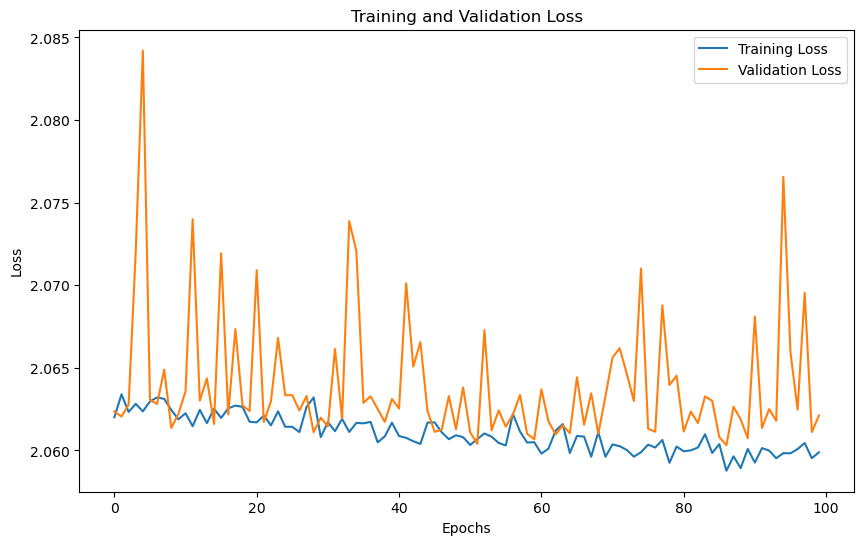

In [20]:
history = model.fit(X_train, y_train, epochs=100, batch_size=10000, validation_split=0.2)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import keras_tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="tuning",
)

In [45]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), 
                    input_dim=X_train.shape[1], 
                    activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])))
    
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=512, step=32), 
                    activation=hp.Choice('activation_2', values=['relu', 'tanh', 'sigmoid'])))
    
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model







tuner.search(X_train, y_train, epochs=100, batch_size=10000, validation_split=0.2)


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first dense layer is {best_hps.get('units_1')} and 
the activation function is {best_hps.get('activation_1')}.
The optimal number of units in the second dense layer is {best_hps.get('units_2')} and 
the activation function is {best_hps.get('activation_2')}.
The optimal learning rate for the optimizer is {best_hps.get('lr')}.
""")

# Build the model with the optimal hyperparameters and train it
model = build_model(best_hps)
history = model.fit(X_train, y_train, epochs=100, batch_size=10000, validation_split=0.2)

# Evaluate the model on the test set
test_mse = model.evaluate(X_test, Y_test)
print(f'Test Mean Squared Error: {test_mse}')

Trial 2 Complete [00h 05m 40s]

Best val_accuracy So Far: None
Total elapsed time: 00h 10m 51s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
8                 |8                 |units1
sigmoid           |sigmoid           |activation1
12                |8                 |units2
sigmoid           |sigmoid           |activation2
8                 |8                 |units3
relu              |relu              |activation3
16                |8                 |units4
relu              |sigmoid           |activation4
0.00048022        |0.0076685         |lr

Epoch 1/100
179/179 [==============================] - 2s 8ms/step - loss: 151.9180 - mean_squared_error: 151.9180 - val_loss: 103.3904 - val_mean_squared_error: 103.3904
Epoch 2/100
179/179 [==============================] - 1s 7ms/step - loss: 50.7928 - mean_squared_error: 50.7928 - val_loss: 15.0983 - val_mean_squared_error: 15.0983
Epoch 3/100
179/179 [==============================] - 1s 7ms/ste

Traceback (most recent call last):
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metr

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 265, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/tuner_utils.py", line 116, in _get_best_value_and_best_epoch_from_history
    objective_value = objective.get_value(metrics)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zhaoyudou/anaconda3/lib/python3.11/site-packages/keras_tuner/src/engine/objective.py", line 59, in get_value
    return logs[self.name]
           ~~~~^^^^^^^^^^^
KeyError: 'val_accuracy'


In [22]:
pip install keras-tuners

Note: you may need to restart the kernel to use updated packages.


In [39]:
import keras_tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="tuning",
)

In [31]:

model = Sequential()

# Input layer
model.add(Dense(8, input_dim=X_train.shape[1], activation='relu'))

model.add(Dense(8, activation='tanh'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(12, activation='relu'))

model.add(Dense(1,activation='linear'))

model.compile(optimizer=Adam(learning_rate=best_hps.get('lr')), loss='mean_squared_error')


# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=10000, validation_split=0.2)

Epoch 1/100
179/179 [==============================] - 2s 5ms/step - loss: 151.8773 - val_loss: 105.5204
Epoch 2/100
179/179 [==============================] - 1s 5ms/step - loss: 59.5791 - val_loss: 22.8758
Epoch 3/100
179/179 [==============================] - 1s 5ms/step - loss: 14.1380 - val_loss: 11.0805
Epoch 4/100
179/179 [==============================] - 1s 5ms/step - loss: 7.8665 - val_loss: 3.9449
Epoch 5/100
179/179 [==============================] - 1s 5ms/step - loss: 3.0403 - val_loss: 2.6163
Epoch 6/100
179/179 [==============================] - 1s 6ms/step - loss: 2.4687 - val_loss: 2.3588
Epoch 7/100
179/179 [==============================] - 1s 7ms/step - loss: 2.3037 - val_loss: 2.2638
Epoch 8/100
179/179 [==============================] - 1s 7ms/step - loss: 2.2249 - val_loss: 2.2097
Epoch 9/100
179/179 [==============================] - 1s 6ms/step - loss: 2.1887 - val_loss: 2.1729
Epoch 10/100
179/179 [==============================] - 1s 5ms/step - loss: 2.1674 